### Design the State Variables 6

For our robot we will maintain the position and orientation:

$$\mathbf x = \begin{bmatrix}x & \dot x & y & \dot y & \theta & \dot \theta\end{bmatrix}^\mathsf{T}$$


The control input $\mathbf{u}$ is the commanded linear velocity and the commanded angular velocity 

$$\mathbf{u} = \begin{bmatrix} \dot x & \dot y & w\end{bmatrix}^\mathsf{T}$$

In [81]:
from math import sin, cos
import numpy as np

class InputOutputLinearization:
    def __init__(self, f_s=100, b=0.05, k1=1, k2=1, epsilon=0.025):
    
        self.f_s = f_s
        self.b = b
        self.k1 = k1
        self.k2 = k2
        self.epsilon = epsilon       
        
    def compute_control_input(self, state, des_position, des_speed):
        x, y, theta = state
        y1 = x + self.b * cos(theta)
        y2 = y + self.b * sin(theta)
        y1_d, y2_d = des_position
        y1_dot_d, y2_dot_d = des_speed

        u1 = y1_dot_d + self.k1 * (y1_d - y1)
        u2 = y2_dot_d + self.k2 * (y2_d - y2)

        T = np.array([[np.cos(theta), -self.b*np.sin(theta)],
                      [np.sin(theta), self.b*np.cos(theta)]])
        T_inv = np.linalg.inv(T)
        v, omega = np.dot(T_inv, np.array([u1, u2]))
        
        return v, omega / 2
    

In [82]:
from scipy.linalg import inv,block_diag
from filterpy.common import Q_discrete_white_noise
from math import tan, sin, cos
from numpy.random import randn
import numpy as np
import matplotlib.pyplot as plt
from filterpy.stats import plot_covariance


class KF_DD:
    def __init__(self,x = np.array([0.,0.,0.,0.,0.,0.]),P=np.diag([.01,.01,.01,.01,.01,.01]),R_var=0.01,Q_var=0.01,dt=0.01):
        self.x = x.T
        self.P = P
        self.F = np.array([[1, dt, 0, 0, 0, 0],
                            [0, 0, 0, 0, 0, 0],
                            [0, 0, 1, dt, 0, 0],
                            [0, 0, 0, 0, 0, 0],
                            [0, 0, 0, 0, 1, dt],
                            [0, 0, 0, 0, 0, 0]])
        self.B = np.array([[0, 0 ,0],
                            [1, 0 ,0],
                            [0, 0 ,0],
                            [0, 1 ,0],
                            [0, 0 ,0],
                            [0, 0 ,1]])
        self.H = self.B.T
        self.R= np.diag([R_var,R_var,R_var])
        self.Q = block_diag(Q_discrete_white_noise(2, dt=dt, var=Q_var), 
                            Q_discrete_white_noise(2, dt=dt, var=Q_var), 
                            Q_discrete_white_noise(2, dt=dt, var=Q_var))
        self.dt = 0
        self.K=[]
          
        
    def predict(self, u):
        self.x = self.F @ self.x + self.B @ u
        self.P = self.F @ self.P @ self.F.T + self.Q
    
    def update(self, z):
        S = self.H @ self.P @ self.H.T + self.R
        self.K = self.P @ self.H.T @ inv(S)
        y = z - self.H @ self.x
        self.x += self.K @ y
        self.P = self.P - self.K @ self.H @ self.P

def kinematic_model(state, control, dt):
    x, y, theta = state
    v, omega = control

    # Derivate del sistema
    dx = v * cos(theta)
    dy = v * sin(theta)
    dtheta = omega

    return np.array([dx, dy, dtheta])

def runge_kutta(state, control, dt):
    k1 = kinematic_model(state, control, dt)
    k2 = kinematic_model(state + 0.5 * dt * k1, control, dt)
    k3 = kinematic_model(state + 0.5 * dt * k2, control, dt)
    k4 = kinematic_model(state + dt * k3, control, dt)

    new_state = state + (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
    return new_state

def move_real(x, dt, u,v_std,w_std):
    v_act = u[0] + randn()*v_std
    w_act = u[1] + randn()*w_std
    theta = x[4]
    x[5]=w
    x[1]=v * cos(theta)
    x[3]=v * sin(theta) 
    
    x[0],x[2],x[4]=runge_kutta((x[0],x[2],x[4]),[v_act,w_act],dt)

    return x 

def runge_kutta_estimator(x, dt, u):
    v = u[0] 
    w = u[1] 
    theta = x[4]
    x[5]=w
    x[1]=v * cos(theta)
    x[3]=v * sin(theta) 
    
    x[0],x[2],x[4]=runge_kutta((x[0],x[2],x[4]),[v,w],dt)

    return x 

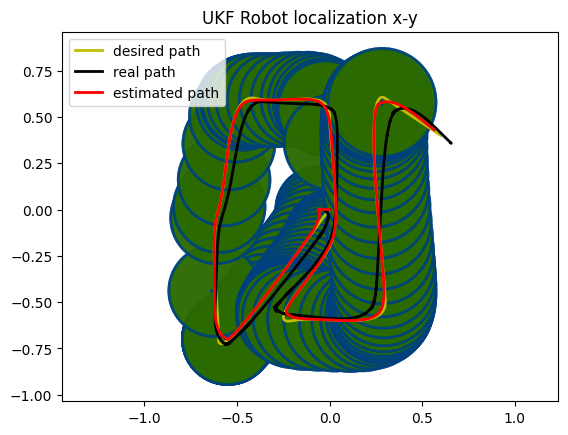

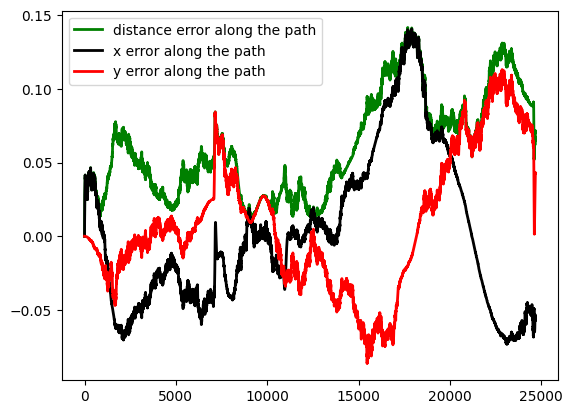

In [83]:
from trajectory_planning.trajectory_planner import *

np.random.seed(42)

#Simulation variable
fs=20
dt=1/fs
initial_pos= np.array([0.,0.,0.,0.,0.,0.])
P=np.diag([.05,.1,.05,.1,.05,.1])
R_var=0.2
Q_var=0.1
v_var=0.05
w_var=0.05

#path generation
path = [(initial_pos[0], initial_pos[2]),(-.6, -.7), (-.6, 0), (-.4, .6), (0, .5), (0, -.2), (-.2, -.6), (.3, -.5), (.3, .6), (.6, .4)]
TP = TrajectoryPlanner(np.zeros((100, 100)), path_list=path)
v_max=0.1
w_max=0.1
x_des, y_des, x_dot_des, y_dot_des, theta_des, theta_dot_des = TP.cartesian_traj(f_s=fs, profile=CUBIC_POL_PROF,trajectory_scaling=True,max_v=v_max,max_w=w_max)

#Class variable
KF=KF_DD(dt=dt,x = initial_pos,P=P,R_var=R_var,Q_var=Q_var)
controller=InputOutputLinearization()
sim_pos=initial_pos.copy()
xs, cov, track= [], [], []
plt.figure()

for i in range(len(x_des)):
    xs.append(KF.x)
    cov.append(KF.P)
    track.append(list(sim_pos))

    v,w=controller.compute_control_input([KF.x[0],KF.x[2],KF.x[4]], [x_des[i],y_des[i]], [x_dot_des[i],y_dot_des[i]])
    u=[v*cos(KF.x[4]),v*sin(KF.x[4]),w]

    #real system
    for j in range(10): 
        sim_pos=move_real(sim_pos, dt/10, u=[v,w], v_std=v_var, w_std=w_var)
      

    #prediction step
    KF.predict(u)
    
    if i%(10*fs)==0:
        cova =np.diag([KF.P[0,0],KF.P[2,2]])
        cova[0,1]=KF.P[0,2]
        cova[1,0]=KF.P[2,0]
        plot_covariance((KF.x[0], KF.x[2]), cov=cova,facecolor='r', alpha=0.8) 

    #mesurement
    z=np.array([sim_pos[1],sim_pos[3],sim_pos[5]])+np.array([R_var*randn(),R_var*randn(),R_var*randn()])
    
    #update step
    KF.update(z)
    
    if i%(10*fs)==0:
        cova =np.diag([KF.P[0,0],KF.P[2,2]])
        cova[0,1]=KF.P[0,2]
        cova[1,0]=KF.P[2,0]
        plot_covariance((KF.x[0], KF.x[2]), cov=cova,facecolor='g', alpha=0.8) 
    
    
 
xs, cov = np.array(xs), np.array(cov)
track = np.array(track)

#plot

plt.plot(x_des, y_des, label='desired path', color='y', lw=2)
plt.plot(track[:, 0], track[:,2],label='real path', color='k', lw=2)
plt.plot(xs[:, 0], xs[:,2],label='estimated path', color='r', lw=2)
plt.legend()
plt.axis('equal')
plt.title("UKF Robot localization x-y")
plt.show()

plt.figure()
plt.plot(np.sqrt((x_des-track[:, 0])**2+(y_des-track[:, 2])**2), label='distance error along the path', color='g', lw=2)
plt.plot(x_des-track[:, 0], label='x error along the path', color='k', lw=2)
plt.plot(y_des-track[:, 2], label='y error along the path', color='r', lw=2)
plt.legend()
plt.show()

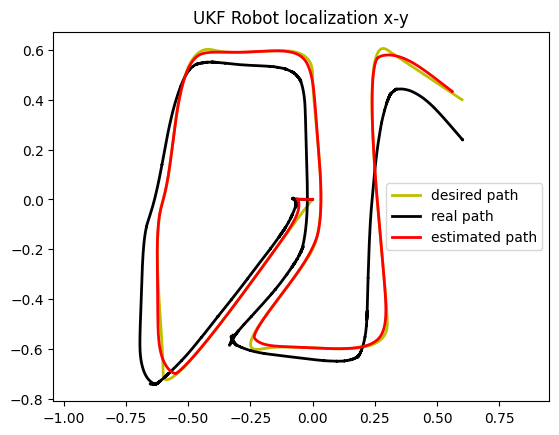

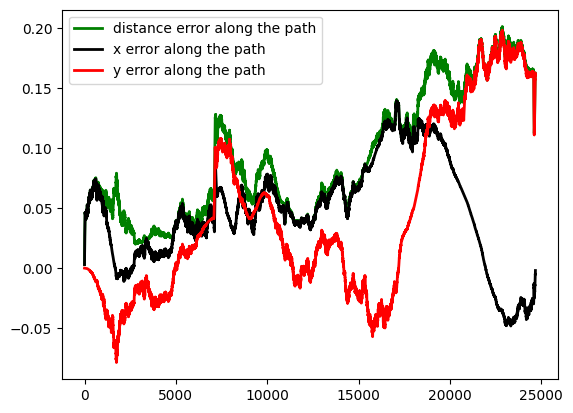

In [84]:
from trajectory_planning.trajectory_planner import *

np.random.seed(42)

#Simulation variable
fs=20
dt=1/fs
initial_pos= np.array([0.,0.,0.,0.,0.,0.])
v_var=0.05
w_var=0.05

#path generation
path = [(initial_pos[0], initial_pos[2]),(-.6, -.7), (-.6, 0), (-.4, .6), (0, .5), (0, -.2), (-.2, -.6), (.3, -.5), (.3, .6), (.6, .4)]
TP = TrajectoryPlanner(np.zeros((100, 100)), path_list=path)
v_max=0.1
w_max=0.1
x_des, y_des, x_dot_des, y_dot_des, theta_des, theta_dot_des = TP.cartesian_traj(f_s=fs, profile=CUBIC_POL_PROF,trajectory_scaling=True,max_v=v_max,max_w=w_max)

#Class variable
controller=InputOutputLinearization()
x_est=initial_pos.copy()
sim_pos=initial_pos.copy()
xs, track= [], []
xs.append(list(x_est))
plt.figure()

for i in range(len(x_des)):
    
    u=controller.compute_control_input([x_est[0],x_est[2],x_est[4]], [x_des[i],y_des[i]], [x_dot_des[i],y_dot_des[i]])

    #real system
    for j in range(10): 
        sim_pos=move_real(sim_pos, dt/10, u=u, v_std=v_var, w_std=w_var)
    track.append(list(sim_pos))  

    x_est=move_real(x_est, dt, u=u, v_std=0., w_std=0.)
    xs.append(list(x_est))
    
 
xs= np.array(xs)
track = np.array(track)

#plot
plt.plot(x_des, y_des, label='desired path', color='y', lw=2)
plt.plot(track[:, 0], track[:,2],label='real path', color='k', lw=2)
plt.plot(xs[:, 0], xs[:,2],label='estimated path', color='r', lw=2)
plt.legend()
plt.axis('equal')
plt.title("UKF Robot localization x-y")
plt.show()

plt.figure()
plt.plot(np.sqrt((x_des-track[:, 0])**2+(y_des-track[:, 2])**2), label='distance error along the path', color='g', lw=2)
plt.plot(x_des-track[:, 0], label='x error along the path', color='k', lw=2)
plt.plot(y_des-track[:, 2], label='y error along the path', color='r', lw=2)
plt.legend()
plt.show()

[1720455041.8048162] - prm executed in 0.069642 seconds
[1720455041.8048162] - Node generation : PRM / num samples: 100 / k: 5
[1720455041.9261835] - bfs executed in 0.121367 seconds
[1720455041.9261835] - BFS Path: [(0, 0), (20, 0), (36, 0), (48, 7), (56, 26), (71, 28), (85, 26), (87, 48), (81, 62), (92, 72), (105, 83), (118, 97), (132, 89), (147, 98), (149, 99)]
[1720455041.9715743] - a_star_search executed in 0.045391 seconds
[1720455041.9715743] - A* Path: [(0, 0), (20, 0), (34, 11), (43, 17), (56, 26), (61, 28), (74, 26), (87, 30), (87, 48), (81, 62), (92, 72), (105, 83), (118, 97), (132, 89), (147, 98), (149, 99)]


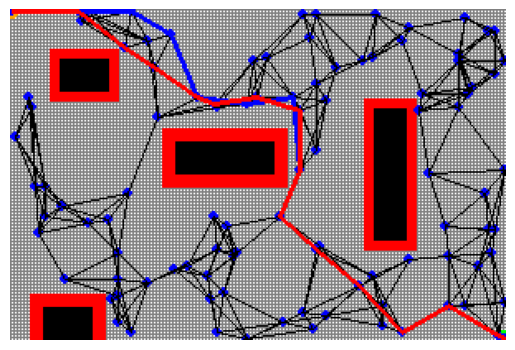

[(0.0, 0.0), (0.2, 0.0), (0.36, 0.0), (0.48, 0.07), (0.56, 0.26), (0.71, 0.28), (0.85, 0.26), (0.87, 0.48), (0.81, 0.62), (0.92, 0.72), (1.05, 0.83), (1.18, 0.97), (1.32, 0.89), (1.47, 0.98), (1.49, 0.99)]


In [85]:
from motion_planning.motion_planner import *
import numpy as np
import matplotlib.pyplot as plt

# Initialization gridmap and Motion planning
gmap = GridMap(1, 1.5, 0.01)
gmap.add_obstacle(10, 15, (15, 15))
gmap.inflate_obstacle(1, 3)
gmap.add_obstacle(40, 10, (110, 30))
gmap.inflate_obstacle(2, 3)
gmap.add_obstacle(10, 30, (50, 40))
gmap.inflate_obstacle(3, 4)
gmap.add_obstacle(10, 15, (10, 90))
gmap.inflate_obstacle(4, 4)
gmap.draw()

# Setup app
pygame.init()
#pygame.display.set_caption('Motion Planning Graph')
width, height = gmap.shape

screen = pygame.Surface((height * CELL_SIZE, width * CELL_SIZE))
# Load background image
bg = pygame.image.load('gridmap.png')

start = (0, 0)
goal = (gmap.shape[1]-1, gmap.shape[0]-1)
motion_planner = MotionPlanner(gmap, NODE_GEN_PRM, start, goal, delta=10)


# Background
screen.blit(bg, (0, 0))
pygame.draw.circle(screen, 'orange', (start[0] * CELL_SIZE+OFFSET, start[1] * CELL_SIZE+OFFSET), 5)
pygame.draw.circle(screen, 'green', (goal[0] * CELL_SIZE+OFFSET, goal[1] * CELL_SIZE+OFFSET), 5)
motion_planner.draw_graph(screen)
motion_planner.draw_path(screen, 'bfs', 'blue')
motion_planner.draw_path(screen, 'a_star', 'red')
# Update screen
#pygame.display.flip()

image = pygame.surfarray.array3d(screen)
# Matplotlib usa immagini con dimensioni (altezza, larghezza, colori), quindi dobbiamo trasporre l'array
image = np.transpose(image, (1, 0, 2))

# Mostra l'immagine con matplotlib
plt.imshow(image)
plt.axis('off')  # Nasconde gli assi
plt.show()

bfs_path = [(round(x * 0.01,2), round(y * 0.01,2)) for x, y in motion_planner.bfs_path]
a_star_path = [(round(x * 0.01,2), round(y * 0.01,2)) for x, y in motion_planner.a_star_path]
print(bfs_path)


204340
0.0 %
0.978760888714887 %
1.957521777429774 %
2.9362826661446606 %
3.915043554859548 %
4.893804443574435 %
5.872565332289321 %
6.851326221004209 %
7.830087109719096 %
8.808847998433983 %
9.78760888714887 %
10.766369775863756 %
11.745130664578642 %
12.723891553293532 %
13.702652442008418 %
14.681413330723302 %
15.660174219438192 %
16.638935108153078 %
17.617695996867965 %
18.596456885582853 %
19.57521777429774 %
20.553978663012625 %
21.532739551727513 %
22.5115004404424 %
23.490261329157285 %
24.469022217872176 %
25.447783106587064 %
26.426543995301948 %
27.405304884016836 %
28.38406577273172 %
29.362826661446604 %
30.3415875501615 %
31.320348438876383 %
32.29910932759127 %
33.277870216306155 %
34.25663110502104 %
35.23539199373593 %
36.21415288245082 %
37.192913771165706 %
38.17167465988059 %
39.15043554859548 %
40.12919643731037 %
41.10795732602525 %
42.08671821474014 %
43.065479103455026 %
44.04423999216991 %
45.0230008808848 %
46.00176176959969 %
46.98052265831457 %
47.959283

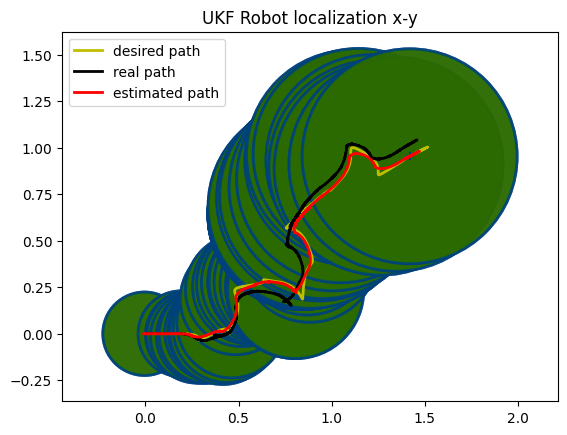

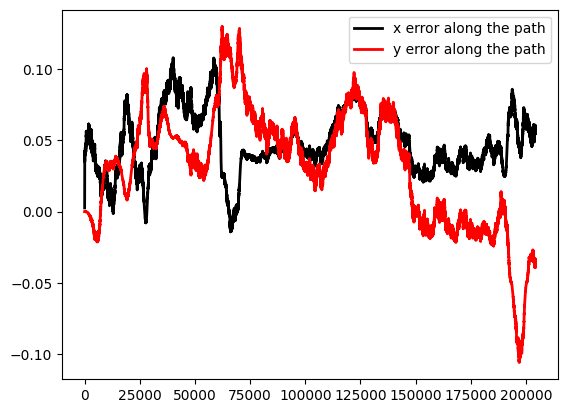

In [86]:
from trajectory_planning.trajectory_planner import *


#Simulation variable
fs=20
dt=1/fs
initial_pos= np.array([0.,0.,0.,0.,0.,0.])
P=np.diag([.05,.1,.05,.1,.05,.1])
R_var=0.2
v_var=0.05
w_var=0.05
Q_var=0.1

#path generation
path = bfs_path
TP = TrajectoryPlanner(np.zeros((100, 100)), path_list=path)
v_max=0.1
w_max=0.1
x_des, y_des, x_dot_des, y_dot_des, theta_des, theta_dot_des = TP.cartesian_traj(f_s=fs, profile=CUBIC_POL_PROF,trajectory_scaling=True,max_v=v_max,max_w=w_max)

#Class variable
KF=KF_DD(dt=dt,x = initial_pos,P=P,R_var=R_var,Q_var=Q_var)
controller=InputOutputLinearization()
sim_pos=initial_pos
xs, cov, track= [], [], []
plt.figure()

print(len(x_des))
for i in range(len(x_des)):
    
    v,w=controller.compute_control_input([KF.x[0],KF.x[2],KF.x[4]], [x_des[i],y_des[i]], [x_dot_des[i],y_dot_des[i]])
    u=[v*cos(KF.x[4]),v*sin(KF.x[4]),w]

    #real system
    for j in range(10): 
        sim_pos=move_real(sim_pos, dt/10, u=[v,w], v_std=v_var, w_std=w_var)
    track.append(list(sim_pos))  

    #prediction step
    KF.predict(u)
    
    if i%(100*fs)==0:
        cova =np.diag([KF.P[0,0],KF.P[2,2]])
        cova[0,1]=KF.P[0,2]
        cova[1,0]=KF.P[2,0]
        plot_covariance((KF.x[0], KF.x[2]), cov=cova,facecolor='r', alpha=0.8) 

    #Noisy mesurement
    z=np.array([sim_pos[1],sim_pos[3],sim_pos[5]])+np.array([R_var*randn(),R_var*randn(),R_var*randn()])
    
    #update step
    KF.update(z)
    
    if i%(100*fs)==0:
        print(i/len(x_des)*100,"%")
        cova =np.diag([KF.P[0,0],KF.P[2,2]])
        cova[0,1]=KF.P[0,2]
        cova[1,0]=KF.P[2,0]
        plot_covariance((KF.x[0], KF.x[2]), cov=cova,facecolor='g', alpha=0.8) 
    
    xs.append(KF.x)
    cov.append(KF.P)
 
xs, cov = np.array(xs), np.array(cov)
track = np.array(track)

#plot

plt.plot(x_des, y_des, label='desired path', color='y', lw=2)
plt.plot(track[:, 0], track[:,2],label='real path', color='k', lw=2)
plt.plot(xs[:, 0], xs[:,2],label='estimated path', color='r', lw=2)
plt.legend()
plt.axis('equal')
plt.title("UKF Robot localization x-y")
plt.show()

plt.figure()
plt.plot(x_des-track[:, 0], label='x error along the path', color='k', lw=2)
plt.plot(y_des-track[:, 2], label='y error along the path', color='r', lw=2)
plt.legend()
plt.show()